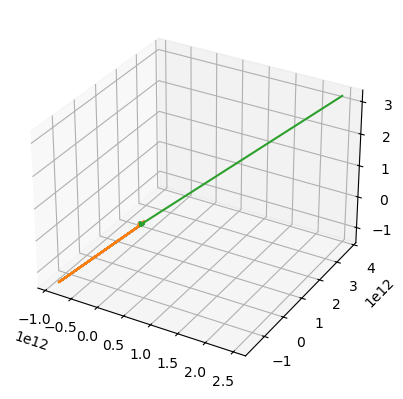

In [5]:
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import numpy as np
from numba import njit





G=6.674*10e-11
N=3

ν=3.156*10**7
t=np.linspace(0,1*ν,10000000)

pos0=np.random.rand(N,3)*10**11
vel0=np.random.rand(N,3)*5*1000
mass=np.random.rand(N)*50*10**29

state0 = np.hstack((pos0.flatten(), vel0.flatten()))

@njit
def acc(state,t):
            pos=state[:3*N].reshape(N,3)
            vel=state[3*N:].reshape(N,3)
            acc = np.zeros((N, 3))

            for i in range (N):
                for j in range (N):
                    if i!=j:
                        rji=pos[j]-pos[i]
                        θ=np.linalg.norm(rji)
                        γ=((G*(mass[i])*(mass[j]))/(θ**3))
                        φ=γ*rji
                        α=φ/mass[i]
                        acc[i]+=α
            return np.hstack((vel.flatten(),acc.flatten()))
                         

sol=odeint(acc,state0,t)
            

fig=plt.figure()
ax=fig.add_subplot(111,projection="3d")

ax.plot(sol.T[0],sol.T[1],sol.T[2])
ax.plot(sol.T[3],sol.T[4],sol.T[5])
ax.plot(sol.T[6],sol.T[7],sol.T[8])
#ax.plot(sol.T[18],sol.T[19],sol.T[20])
